In [1]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary
from sklearn.metrics import accuracy_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [3]:
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES,
                             cluster_std = 1.5, random_state=RANDOM_SEED)

In [4]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


In [5]:
print(X_blob.shape, y_blob.shape)

torch.Size([1000, 2]) torch.Size([1000])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

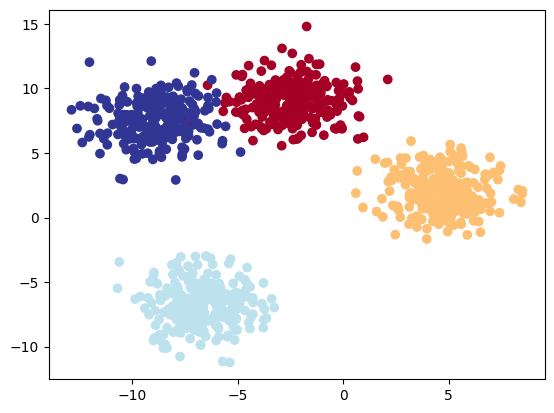

In [7]:
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [8]:
class BlobModel(nn.Module):
    """
    """
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.layer(x)

In [9]:
model = BlobModel(input_features=2, output_features=4).to(device)
print(model)
print(next(model.parameters()))
#print(model.state_dict())

BlobModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)
Parameter containing:
tensor([[ 0.5370, -0.4896],
        [-0.5096,  0.5525],
        [ 0.6655, -0.6288],
        [-0.4055, -0.0072],
        [-0.2615,  0.4612],
        [ 0.4830,  0.0658],
        [ 0.1389,  0.3944],
        [-0.6185,  0.6334]], device='cuda:0', requires_grad=True)


In [10]:
with torch.inference_mode():
    untrained_y = model(X_test)

In [11]:
untrained_y[0:5]
untrained_predictions = torch.softmax(untrained_y, dim=1).argmax(dim=1)


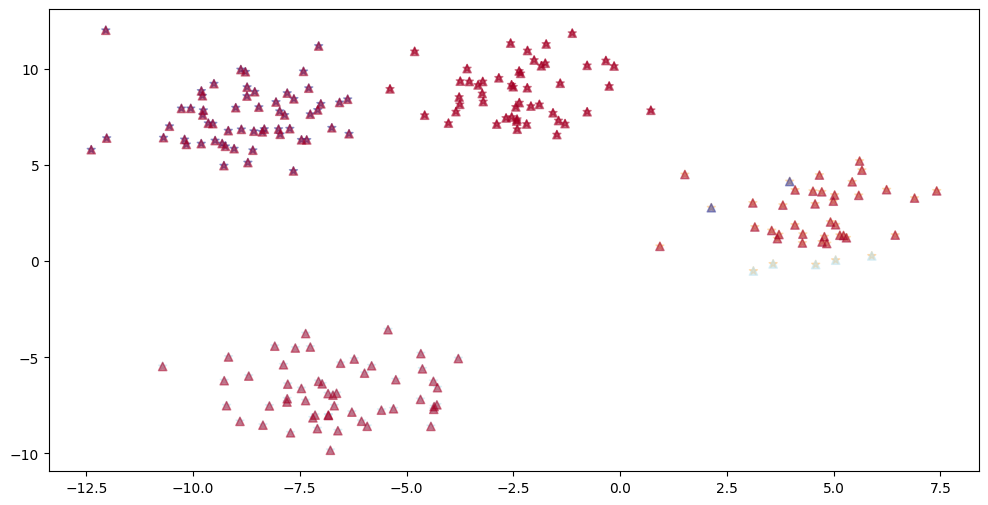

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(X_test[:,0].cpu(), X_test[:,1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu, marker='*', alpha=0.5)
plt.scatter(X_test[:,0].cpu(), X_test[:,1].cpu(), c=untrained_predictions.cpu(), cmap=plt.cm.RdYlBu, marker='^', alpha=0.5)

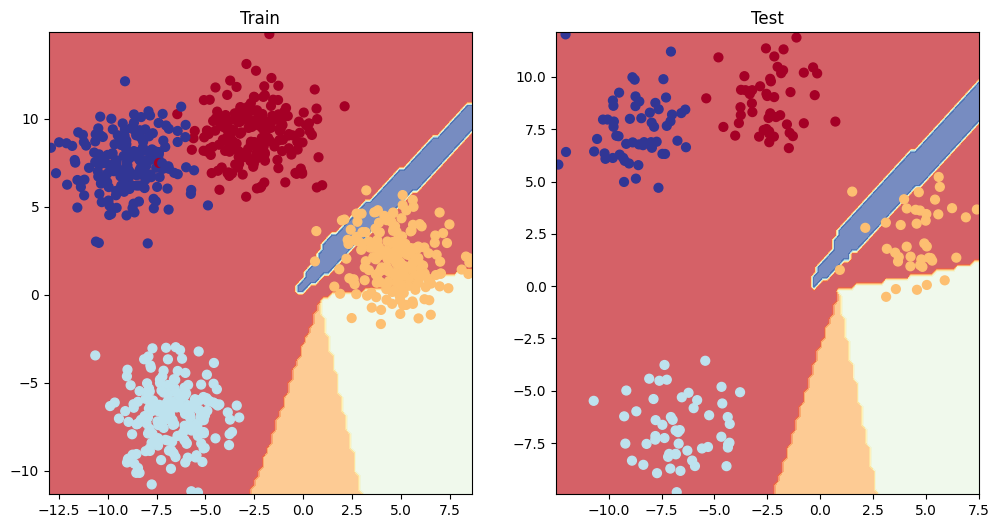

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train.cpu(), y_train.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test.cpu(), y_test.cpu())

In [14]:
# Loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [16]:
epochs= 100

In [18]:
model

BlobModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [20]:
for epoch in range(epochs):
    model.to(device)
    model.train()
    y_logits = model(X_train)
    y_pred  = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    if epoch % 10 == 0:
        ## Testing
        model.eval()
        with torch.inference_mode():
            y_test_logits = model(X_test)
            y_test_predictions = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
            test_accuracy = accuracy_score(y_test.cpu().numpy(),y_test_predictions.cpu().numpy())
            test_loss = loss_fn(y_test_logits, y_test)
            print(f'Epoch {epoch} Train Loss {loss} Test Loss {test_loss} Test Accuracy {test_accuracy}')
        

Epoch 0 Train Loss 1.3496121168136597 Test Loss 1.2414458990097046 Test Accuracy 0.0
Epoch 10 Train Loss 0.9097689986228943 Test Loss 0.8871002197265625 Test Accuracy 0.74
Epoch 20 Train Loss 0.6672014594078064 Test Loss 0.6696038842201233 Test Accuracy 0.915
Epoch 30 Train Loss 0.5294544100761414 Test Loss 0.5359787940979004 Test Accuracy 0.855
Epoch 40 Train Loss 0.3771979808807373 Test Loss 0.3666294813156128 Test Accuracy 0.945
Epoch 50 Train Loss 0.18595647811889648 Test Loss 0.17056265473365784 Test Accuracy 0.985
Epoch 60 Train Loss 0.09770292043685913 Test Loss 0.09139049798250198 Test Accuracy 0.99
Epoch 70 Train Loss 0.06834882497787476 Test Loss 0.06325730681419373 Test Accuracy 0.99
Epoch 80 Train Loss 0.054520703852176666 Test Loss 0.04907071962952614 Test Accuracy 0.99
Epoch 90 Train Loss 0.046686772257089615 Test Loss 0.040760960429906845 Test Accuracy 0.995


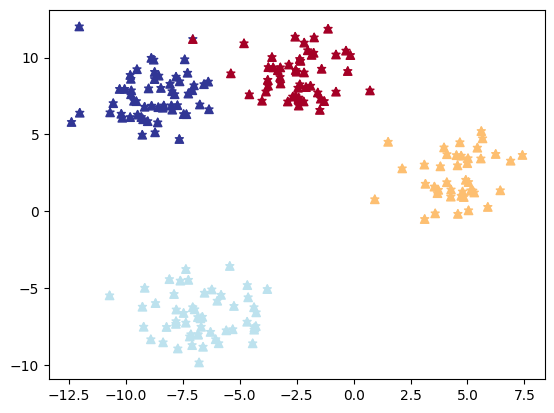

In [22]:
plt.scatter(X_test[:,0].cpu(), X_test[:,1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu, marker='*')
plt.scatter(X_test[:,0].cpu(), X_test[:,1].cpu(), c=y_test_predictions.cpu(), cmap=plt.cm.RdYlBu, marker='^')

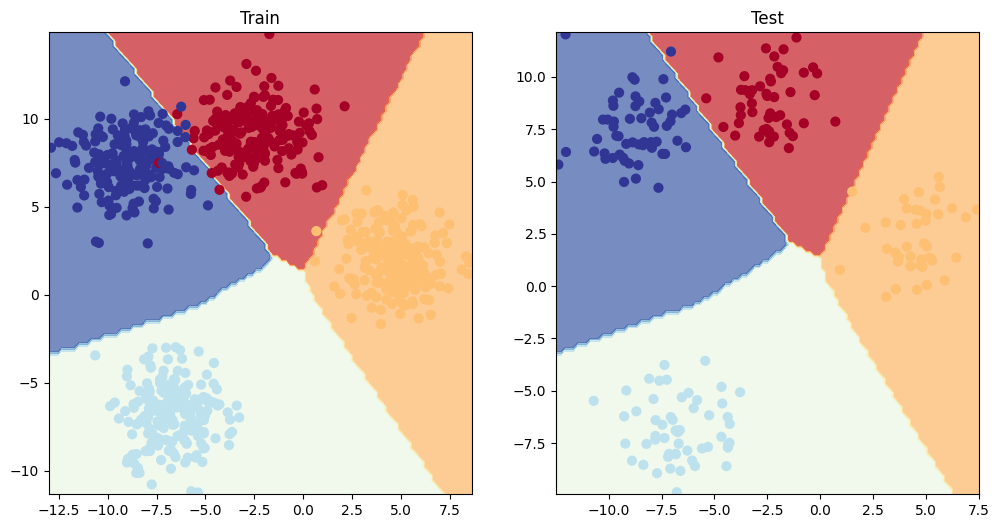

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train.cpu(), y_train.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test.cpu(), y_test.cpu())

In [27]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass',num_classes=4).to(device)

# Calculuate accuracy
torchmetric_accuracy(y_test_predictions, y_test)
     

tensor(0.9950, device='cuda:0')